# Evaluation and Multi-Layer Perceptron
####  How to make a brain and evaluate it good

## Preparation
### [5 points] Business Case Explanation
(mostly the same processes as from lab four) Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the task is and what parties would be interested in the results. How well would your prediction algorithm need to perform to be considered useful by interested parties?

### Introduction to Our Problem
There are literally tens of thousands of movies out there today. While some do great at the box office and bring in a lot of money, others flop making only a fraction compared to the top hits. What if we had a scientific way of accurately predicting how much revenue a movie would generate over its lifetime? Well, through machine learning we believe that we actually can!

The dataset we are using is found on <a href="https://www.kaggle.com/deepmatrix/imdb-5000-movie-dataset">Kaggle</a>. It consists of 5000+ movies scraped from the review site IMDB. There is quite a bit of data recorded for each movie and so we had a lot to work with to try to predict the next big hit. The data was collected from web scraping IMDB using a python library called "scrappy" to collect all of the data below. The features recorded for each movie are: 

Basic Info:
- movie title
- color (black and white or color)	
- duration of the movie
- director name
- gross (total revenue)
- genres (a lits of different genres ascribed to the movie)
- number of faces in movie poster
- language of the movie
- country the movie was produced in
- content rating (G, PG, PG-13, R, NC-17)
- budget
- year of release
- aspect ratio
- name of the 3rd actor
- name of the 2nd actor
- name of the 1st actor

Facebook Info:
- number of director facebook likes
- number of facebook likes for the whole cast
- number of the movie's facebook likes
- number of the 3rd actor's facebook likes
- number of the 2nd actor's facebook likes
- number of the 1st actor's facebook likes

IMDB Specific Info:
- number of imdb users who rated the movie
- number of critical reviews for the movie
- number of users who left a review
- imdb score
- top plot keywords


With all of this data collected on so many movies, we hope to be able to use this to build out a multi-layer perceptron  to accurately predict the financial success (measured in categories of gross revenue: low, low-mid, high-mid, and high) of a movie. We think that this could be a useful tool to anyone in the movie industry who is concerned with making a profit on their movie. It could also help a producer understand which of these features are the most important to an accurate prediction, what content rating is most important, how budget affects outcome, etc.

### Data Pre-processing:

Pre-processing of the CSV:
- We first removed the imdb link from the csv because we knew we would never need to use that (**Note: this was the only feature removed from the csv**)
- We then went through and deleted all of the movies that were made in another country (foriegn films) we did this because we wanted to just look at American films, also because the currency units for those countries (for budget and gross) were in native currency units, not USD, and with changing exchange rates, it's not very easy to compare across countries.
- We then went through and converted all 0 values for gross, movie_facebook_likes, and director_facebook_likes to a blank value in the csv (so that it is read in as NaN by pandas), this is so that we cna more easily impute values later. Note: according to the description on the kaggle entry, because of the way the data was scraped, some movies had missing data. The Python scraper just made these values into a 0 instead of NaN.
- We then removed all movies with an undefined gross. Being the feature we are trying to predict, we should not be imputing values for gross to train our model. That will basically reduce our model to an imputation algorithm...
- We then removed all movies that were made before 1935. We did this because there were only a handful of movies ranging from 1915 to 1935, the way we are classifying budget (described below) would not work with a small sample of movies from that time period. We could have cut this number at a different year (say 1960), but we didn't want to exclude such classics as "Bambi" or "Gone With the Wind"

Pre-processing of the Data:
- After the above steps, we made more edits to the data using pandas. First, we removed features that we thought would be un-useful to our prediction algorithm. We removed all features concerning facebook likes. We did this because a significant portion of the movies in the training set debuted before facebook was invented and widely adopted. While some of these movies have received retroactive "likes" on facebook, only the most famous classics received a substantial amount of retraoctive "likes". Most lesser known films received very low amounts of "likes" (presumably because modern movie watchers don't really care to search for lesser known movies on facebook, or because the movie doesn't have a facebook). For this reason we decided to remove movie_facebook_likes
- Likewise, we removed the other "likes" for the same reasons as above. For example, the esteemed director George Lucas has a total of 0 "likes" between all of his films. This feature obviously would not help us predict the profitability of movies.
- We also removed irrelevant information such as aspect_ratio, language, and country. Because we deleted all foreign films the country will always be USA. A simple filter of the data reveals that there are no more than 20 movies made in the US that use a language other than English, therefore there is not enough data to use language as training feature. However, we did not delete the movies in a different language, because most of them were famous films such as *Letters from Iwo Jima* and *The Kite Runner*. We still count them as a valuable part of the dataset, just don't find the language of particular value. Lastly, we removed aspect_ratio because that seems to be unimportant for predicting the success of a movie.

### [10 points] Define and Prepare Class Variables
 (mostly the same processes as from lab one) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

In [1]:
# Take the dataframe and adjust for inflation and then use the df_to_csv function to export to csv 
# and then export to csv and then delete code

import pandas as pd
import numpy as np
df = pd.read_csv("inflation_corrected_dataset.csv")
for x in ['movie_facebook_likes', 'director_facebook_likes', 'actor_2_facebook_likes', 
          'actor_1_facebook_likes','actor_3_facebook_likes', 'cast_total_facebook_likes',
          'aspect_ratio', 'language', 'country', 'plot_keywords', 'actor_3_name', 'actor_2_name', 'movie_title', 'genres', 'color']:
    if x in df:
        del df[x]
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3222 entries, 0 to 3221
Data columns (total 12 columns):
director_name             3222 non-null object
num_critic_for_reviews    3219 non-null float64
duration                  3221 non-null float64
gross                     3222 non-null int64
actor_1_name              3220 non-null object
num_voted_users           3222 non-null int64
facenumber_in_poster      3216 non-null float64
num_user_for_reviews      3221 non-null float64
content_rating            3196 non-null object
budget                    3062 non-null float64
title_year                3222 non-null int64
imdb_score                3222 non-null float64
dtypes: float64(6), int64(3), object(3)
memory usage: 302.1+ KB
None


In [2]:
# Tamper with the groupings to improve imputations? How do we improve how many values get imputed?
df_grouped = df.groupby(by=['director_name'])
# director_name adds about 50 rows (imputes about 50 rows and then deletes about 100)

In [3]:
df_imputed = df_grouped.transform(lambda grp: grp.fillna(grp.median()))
col_deleted = list( set(df.columns) - set(df_imputed.columns)) #in case the median op deleted columns
df_imputed[col_deleted] = df[col_deleted]

# drop rows that still have missing values after imputation
df_imputed.dropna(inplace=True)
print(df_imputed.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3127 entries, 0 to 3220
Data columns (total 12 columns):
num_critic_for_reviews    3127 non-null float64
duration                  3127 non-null float64
gross                     3127 non-null int64
num_voted_users           3127 non-null int64
facenumber_in_poster      3127 non-null float64
num_user_for_reviews      3127 non-null float64
budget                    3127 non-null float64
title_year                3127 non-null int64
imdb_score                3127 non-null float64
content_rating            3127 non-null object
director_name             3127 non-null object
actor_1_name              3127 non-null object
dtypes: float64(6), int64(3), object(3)
memory usage: 317.6+ KB
None


### Scaling the Data
Below we scale the data using the methods shown so as to not adversely affect the gamma value. We scaled down all of the numerical values to be within -1 and 1. We also one-hot encode the content rating. We forego encoding the director name or actor names because they proved to make our matrix way too large to run computations on.

In [4]:
%%time
#scaling budgets!
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_rows', 200)

budget = df_imputed['budget'].values.reshape(-1, 1)
df_imputed.reset_index(drop=True, inplace=True)
print("df: ",df_imputed.shape)

append_list = [df_imputed]

df = pd.concat(append_list, axis=1)

#one-hot encode
hot_content = pd.get_dummies(df_imputed.content_rating, prefix='contentRating')

print(df.shape)

df:  (3127, 12)
(3127, 12)
Wall time: 241 ms


### Cutting the gross into categories
Below we cut the adjusted, scaled, gross into 4 main categories: low, low-mid, high-mid, and high. We did this because otherwise the model would not be able to produce raw gross accurately. We also used the "qcut" function to evenly distribute the classes among the classifications, because when we did a normal cut method most of the classes would fall in the lowest category and throw off our predictions.

In [5]:
from sklearn.preprocessing import LabelEncoder

spacing = np.linspace(0, max(df['gross']), 100)
labels = []

labels = ["low", "low-mid", "high-mid", "high"]
df['gross_group'] = pd.qcut(df['gross'], 4, labels=labels)


rating_group = df['gross_group'].values
rating_encoder = LabelEncoder()
rating_df = pd.DataFrame(rating_encoder.fit_transform(rating_group), columns=['encoded_gross']).astype(str)
df = pd.concat([df, rating_df], axis=1)


Because it took too much time to adjust for inflation, we just did that and then exported it to a csv and then slapped that momma up with some secret sauce.

___

## Evaluation
### [15 points] Choose and explain evaluation metrics
Choose and explain what metric(s) you will use to evaluate your algorithm’s generalization performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

- Having false positives is TERRIBLE because then somebody will be SCREWED because they will make the movie thinking they will make money but they don't
- Having false negatives is not as bad, because it means the director will pass on the movie, menaing they will miss out on the opportunity but won't make money

In [6]:
from sklearn.metrics import confusion_matrix

cost_matrix = np.array([-1,10, 14,20,2,-1,10,14,4,2,-1,10,6,4,2,-1]) #give a reason for why these numbers chosen
cost_matrix = cost_matrix.reshape(4,4)
print(cost_matrix)

[[-1 10 14 20]
 [ 2 -1 10 14]
 [ 4  2 -1 10]
 [ 6  4  2 -1]]


### [15 points] Method for dividing up training/testing data
Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

In [7]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
cv = StratifiedKFold(n_splits=10)

drop_list = ['encoded_gross', 'gross_group', 
              'gross', 'director_name', 'actor_1_name', 'content_rating']
X = df.drop(drop_list, axis=1).values
y = df['encoded_gross'].values.astype(np.float) # x and y are now np.matrices 

X = StandardScaler().fit_transform(X)

- cpnvert dataframe to np matrix
- 

___

## Modeling
### [20 points] Custom MLP
 Create a custom implementation of the multi-layer perceptron. Start with the implementation given to you in the course. Update the MLP class to:
- When instantiated, use a selectable nonlinearity function for the first layer: either sigmoid or linear 
- Use a selectable cost function when instantiated: either quadratic or cross entropy


In [8]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka
# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30, nonlinear="sigmoid",
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.nonlinear = nonlinear
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot
    
    #Initialization used in RELU
    def _initialize_weights(self):
        if self.nonlinear == "linear":
            const1 = 6.
            const2 = 6.
        elif self.nonlinear == "sigmoid":
            const1 = 2.
            const2 = 2.
        elif self.nonlinear == "relu":
            const1 = 6.
            const2 = 2.
        """Initialize weights with small random numbers."""
        # suggested relu/sigmoid bounds
        # Glorot, Xavier, Antoine Bordes, and Yoshua Bengio. 
        #   "Deep Sparse Rectifier Neural Networks."
        init_bound = np.sqrt(const1 / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))

        init_bound = np.sqrt( const2 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1))
        return W1, W2
    
    @staticmethod
    def _relu(Z):
        return np.maximum(0,Z.copy())
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        Z1 = W1 @ A1.T
        if self.nonlinear == "sigmoid":  #A1->W1->Sigmoid->A2->W2->Sigmoid
            A2 = self._sigmoid(Z1)
        elif self.nonlinear == "linear": #A1->W1->Linear->A2->W2->Linear
            A2 = Z1
        elif self.nonlinear == "relu": #A1->W1->Relu->A2->W2->Sigmoid
            A2 = self._relu(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        if self.nonlinear == 'sigmoid' or self.nonlinear == 'relu':
            A3 = self._sigmoid(Z2)
        elif self.nonlinear == 'linear':
            A3 = Z2
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        if self.nonlinear == 'sigmoid': 
            sigma3 = -2*(Y_enc-A3)*A3*(1-A3)
            sigma2 = (W2.T @ sigma3)*A2*(1-A2)
        elif self.nonlinear == 'linear':
            sigma3 = -2*(Y_enc-A3)
            sigma2 = (W2.T @ sigma3)
        elif self.nonlinear == 'relu':
            sigma3 = (A3-Y_enc) 
            sigma2 = (W2.T @ sigma3) 
            Z1_with_bias = self._add_bias_unit(Z1,how='row')
            sigma2[Z1_with_bias<=0] = 0

        grad1 = sigma2[1:,:] @ A1
        grad2 = sigma3 @ A2.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [9]:
from sklearn.metrics import accuracy_score
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                delta_W1, delta_W2 = self.eta * grad1, self.eta * grad2
                self.W1 -= (delta_W1 + (self.alpha * delta_W1_prev))
                self.W2 -= (delta_W2 + (self.alpha * delta_W2_prev))
                delta_W1_prev, delta_W2_prev = delta_W1, delta_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
        return self
    

In [10]:
# to implement the new style of objective function, 
# we just need to update the final layer calculation of the gradient
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        sigma3 = (A3-Y_enc) # <- this is only line that changed
        if self.nonlinear == 'sigmoid':
            sigma2 = (W2.T @ sigma3)*A2*(1-A2)
        elif self.nonlinear == 'linear':
            sigma2 = (W2.T @ sigma3)
        elif self.nonlinear == 'relu':
            sigma2 = (W2.T @ sigma3) 
            Z1_with_bias = self._add_bias_unit(Z1,how='row')
            sigma2[Z1_with_bias<=0] = 0
        grad1 = sigma2[1:,:] @ A1
        grad2 = sigma3 @ A2.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
        

In [11]:
class TLPWrapper(object):
    def __init__(self, cost_func="quad",**kwds):
        self.cost_func = cost_func    #quad or cross_ent
        if self.cost_func == "cross_ent":
            self.neural = TLPMiniBatchCrossEntropy(**kwds)
        elif self.cost_func == "quad":
            self.neural = TLPMiniBatch(**kwds)
        else:
            print("Invalid cost function chosen. Pick either 'quad' or 'cross_ent'")
    def fit(self, x_train, y_train):
        self.neural.fit(x_train, y_train)
    def predict(self, x_test):
        return self.neural.predict(x_test)
            
    

### [15 points] Tune hyper-parameters, visualize eval metrics with diff hyper-parameters
Tune the hyper-parameters of your MLP model (at least two hyper-parameters). While tuning hyper-parameters, analyze the results using your chosen metric(s) of evaluation. Visualize the evaluation metric(s) versus the hyper-parameters. Conclude what combination of parameters are best.


In [12]:
%%time
#Tuning hidden neurons
hidden_confusion_list = []
neuron_list = []
for x in range(10, 100, 10):
    neuron_list.append(x)
    cross_ent_confusion = []
    vals = {'n_hidden': x, 
             'C':0.0, 'epochs':50, 'eta':0.001, 
             'alpha':0.0, 'decrease_const':1e-5, 'minibatches':128,
            'shuffle':True,'random_state':1, 'nonlinear': 'sigmoid'}
    for train_index, test_index in cv.split(X, y):

        X_train = X[train_index]
        X_test = X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        cross_ent_nn = TLPWrapper(cost_func="cross_ent", **vals)

        cross_ent_nn.fit(X_train, y_train)

        yhat = cross_ent_nn.predict(X_test)
        cross_ent_confusion.append(confusion_matrix(y_test, yhat)*cost_matrix)

    hidden_confusion_list.append(cross_ent_confusion)
    

Wall time: 2min 2s


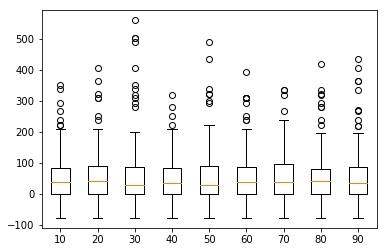

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure()
plt.boxplot(hidden_confusion_list, labels=neuron_list)
plt.show()


In [14]:
%%time
#Tuning nonlinearity function
nonlinear_confusion_list = []
nonlinear_list = ['linear', 'sigmoid', 'relu']
for x in nonlinear_list:
    cross_ent_confusion = []
    vals = {'n_hidden': 100, 
             'C':0.0, 'epochs':50, 'eta':0.001, 
             'alpha':0.0, 'decrease_const':1e-5, 'minibatches':128,
            'shuffle':True,'random_state':1, 'nonlinear': x}
    for train_index, test_index in cv.split(X, y):

        X_train = X[train_index]
        X_test = X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        cross_ent_nn = TLPWrapper(cost_func="cross_ent", **vals)

        cross_ent_nn.fit(X_train, y_train)

        yhat = cross_ent_nn.predict(X_test)
        cross_ent_confusion.append(confusion_matrix(y_test, yhat) * cost_matrix)

    nonlinear_confusion_list.append(cross_ent_confusion)
    

D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in log


Wall time: 50.5 s


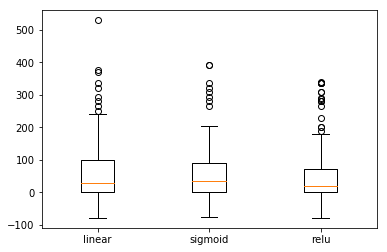

In [15]:
plt.figure()
plt.boxplot(nonlinear_confusion_list, labels=nonlinear_list)
plt.show()

### [10 points] Compare custom MLP to scikit-learn
Compare the performance of your MLP training procedure to scikit-learn. Which implementation is better in terms of generalization performance, computation time, and memory used while training?

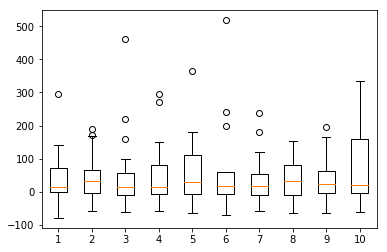

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                    activation='relu', # type of non-linearity, every layer
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size= 'auto', # min of 200, num_samples
                    learning_rate='constant', # adapt learning? only for sgd
                    learning_rate_init=0.1, # only SGD
                    power_t=0.0,    # only SGD with inverse scaling of learning rate
                    max_iter=75, # stopping criteria
                    shuffle=True, 
                    random_state=1, 
                    tol=0, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=False, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.0, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

sk_confusion = []
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train,y_train)
    yhat = clf.predict(X_test)
    sk_confusion.append(confusion_matrix(y_test, yhat) * cost_matrix)

plt.figure()
plt.boxplot(sk_confusion)
plt.show()

___

## Exceptional Work
One idea: Add support for more than one hidden layer or a different nonlinear activation (i.e., softmax, tanh). Please note that different activation functions might require different weight initializations to work well. 

- Hidden layer: input - hidden - output layer. You get to select how many neurons are in the hidden layer. Evrything before the output layer is a hidden layer. Output layer is set, because its the number of classes we want to predict. That means there are 4 neourons at the output layer for us since w ehave 4 classes.

- Dead neouron: one that never gets updated in the gradient. Like when the sigmoid gradient is always at 0 (if you've initiliazed very poorly). Relu nonlinearity can give you some dead neurons but not as many

___